In [1]:
import pandas as pd
import re,contractions
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import warnings
# warnings.filterwarnings('ignore')
import wordcloud
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
import wordninja
from nltk.stem import WordNetLemmatizer
import pickle
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./Suicide_Detection.csv")
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [3]:
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)
df

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...
232069,If you don't like rock then your not going to ...,non-suicide
232070,You how you can tell i have so many friends an...,non-suicide
232071,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,The usual stuff you find hereI'm not posting t...,suicide


In [4]:
df.shape

(232074, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


In [6]:
df.isna().sum()

text     0
class    0
dtype: int64

In [7]:
df['class'].unique()

array(['suicide', 'non-suicide'], dtype=object)

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
wnl = nltk.WordNetLemmatizer()

In [10]:
#emoji
def convertEmojiToText(text):
    demojized_text = emoji.demojize(text)
    text = re.sub(r'[^\w\s]', '', demojized_text)
    return text

df['text'] = df['text'].apply(convertEmojiToText)

In [11]:
df

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I dont get affected by compliments ...,non-suicide
2,Finally 2020 is almost over So I can never hea...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,Im so lostHello my name is Adam 16 and Ive bee...,suicide
...,...,...
232069,If you dont like rock then your not going to g...,non-suicide
232070,You how you can tell i have so many friends an...,non-suicide
232071,pee probably tastes like salty teasmirking_fac...,non-suicide
232072,The usual stuff you find hereIm not posting th...,suicide


In [12]:
# Function to clean text and apply contraction fix safely
def safe_contractions_fix(text):
    if isinstance(text, str):  # Ensure text is a string
        try:
            # Apply contractions fix
            return contractions.fix(text)
        except Exception as e:
            print(f"Error processing text: {text}")
            print(e)
            return text  # Return the text as is in case of error
    return text  # If it's not a string, return as is

# Apply the safe contractions fix to the DataFrame column
df['text'] = df['text'].apply(safe_contractions_fix)


Error processing text: İ am losing my mindİ dont know how i can endure this bullshit   
İam 21 and suffered almost every stage of my life  things are not going on my way  worst thing is everyone hates me even my family too  They think iam a failure
İam an university student but my grades like an  rotten apple on the tree i have no motivation or energy And dont have a girlfriend still virgin  Why i should keep up for nothing   for more suffer  or more failure 
İ just want peace  love and some money
İ know there is still some hope but i tired keep fighting it is pointless  i hate it i just want some victory  İ am looking for a gun but it is hard to access on my country  İ just dont want hurt anymore it is enough  İf people interested in motivational videos please watch 
Why we choose suicide Mark Henic it relaxed me one bit  İ need your prays too
string index out of range
Error processing text: İ have seen a weird dream  Warning please readİn my dream  i was committing to suicide with kn

In [13]:
df['text']

0         Ex Wife Threatening SuicideRecently I left my ...
1         Am I weird I do not get affected by compliment...
2         Finally 2020 is almost over So I can never hea...
3               i need helpjust help me i am crying so hard
4         I Am so lostHello my name is Adam 16 and I Hav...
                                ...                        
232069    If you do not like rock then your not going to...
232070    You how you can tell i have so many friends an...
232071    pee probably tastes like salty teasmirking_fac...
232072    The usual stuff you find hereIm not posting th...
232073    I still have not beaten the first boss in Holl...
Name: text, Length: 232074, dtype: object

In [14]:
# Initialize the lemmatizer globally
wnl = WordNetLemmatizer()

def clean_text(text):
    """Clean text by removing punctuation, special characters, and handling concatenated words."""
    if not isinstance(text, str):
        return ""  # Return an empty string for non-string values
    
    # Remove URLs, HTML tags, and newline characters
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'\n', ' ', text)  # Replace newline with space

    # Remove punctuation and special characters, except spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize text
    tokens = word_tokenize(text)

    # Lemmatize tokens
    lemmatized_tokens = [wnl.lemmatize(t, pos="v") for t in tokens]

    # Handle concatenated words using wordninja
    processed_words = []
    for word in lemmatized_tokens:
        split_words = wordninja.split(word)
        processed_words.extend(split_words)

    # Remove any empty tokens
    processed_words = list(filter(None, processed_words))

    # Join the tokens back into a single string
    return ' '.join(processed_words)

# Ensure all entries in the 'text' column are strings
df['text'] = df['text'].astype(str)

# Apply the clean_text function to the DataFrame column
df['text'] = df['text'].apply(clean_text)


In [15]:
df['text']

0         ex wife threaten suicide recently i leave my w...
1         be i weird i do not get affect by compliment i...
2         finally 2020 be almost over so i can never hea...
3                 i need help just help me i be cry so hard
4         i be so lost hello my name be adam 16 and i ha...
                                ...                        
232069    if you do not like rock then your not go to ge...
232070    you how you can tell i have so many friends an...
232071    pee probably taste like salty tea smirking fac...
232072    the usual stuff you find here im not post this...
232073    i still have not beat the first boss in hollow...
Name: text, Length: 232074, dtype: object

EDA

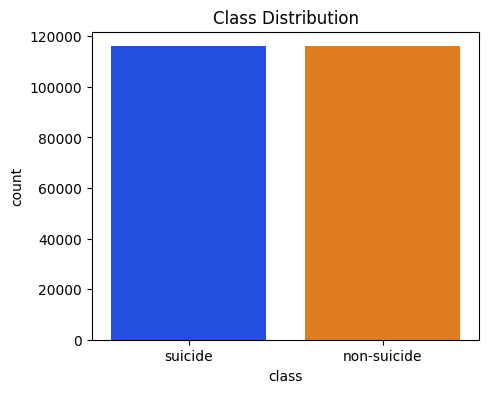

In [16]:
# check for class balancing
plt.figure(figsize=(5,4))
sns.countplot(x="class", data=df, palette="bright")
plt.title("Class Distribution")
plt.show()

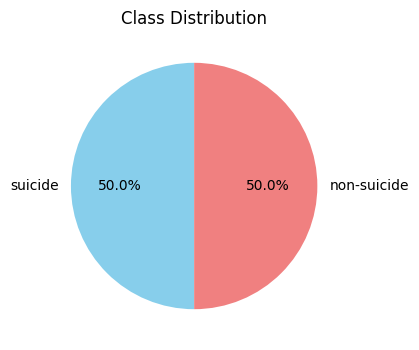

In [17]:
# pie chart for class distribution
plt.figure(figsize=(5,4))
df['class'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors= ['skyblue', 'lightcoral'])
plt.title('Class Distribution')
plt.ylabel('') 
plt.show()

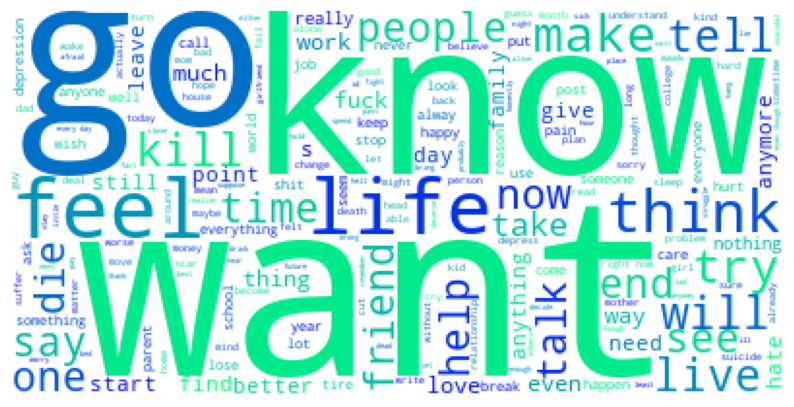

In [18]:
# word cloud for suicide
suicide=df[df['class']=='suicide']['text']
non_suicide=df[df['class']=='non-suicide']['text']

def display_cloud(data):
    plt.subplots(figsize=(10,10))
    wc = wordcloud.WordCloud(
                   background_color="white",
                   colormap='winter_r',
                   max_words=500,
                   random_state=42)
    plt.imshow(wc.generate(' '.join(data)))
    plt.axis('off')
    plt.show()

display_cloud(suicide)

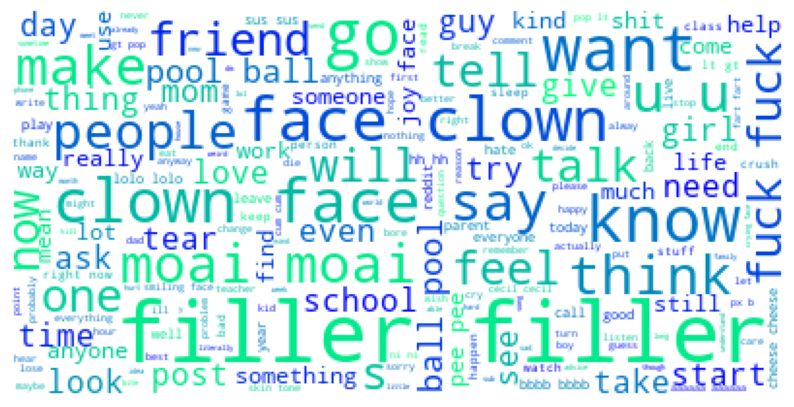

In [19]:
# word cloud for non-suicide
display_cloud(non_suicide)

In [16]:
# nltk.download('punkt')
# nltk.download('stopwords')

# tokenization
df['text'] = df['text'].apply(lambda x: word_tokenize(x))

# remove stop words
stop_words = set(stopwords.words("english"))
df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stop_words])

In [17]:
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])  # non-suicide = 0, suicide = 1
df.head()

,text,class
0,"[ex, wife, threaten, suicide, recently, leave,...",1
1,"[weird, get, affect, compliment, come, someone...",0
2,"[finally, 2020, almost, never, hear, 2020, bad...",0
3,"[need, help, help, cry, hard]",1
4,"[lost, hello, name, adam, 16, struggle, years,...",1


TfidfVectorizer with standard scaler

In [18]:
# TF-IDF
# Ensure all elements are strings
df['text'] = df['text'].astype(str)
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df['text'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_text, df['class'], test_size=0.2, random_state=42)

In [23]:
# pickling the vectorizer

pickle_out = open("Vectorizer.pkl", "wb")
pickle.dump(vectorizer, pickle_out)
pickle_out.close()

In [19]:
# Normalization
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
# pickling the scaler

pickle_out = open("Scaler.pkl", "wb")
pickle.dump(scaler, pickle_out)
pickle_out.close()

Logistic Regression

In [26]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
print("\nLogistic Regression Model Performance:")
print(classification_report(y_test, lr_preds))
print(accuracy_score(y_test, lr_preds))


Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     23287
           1       0.94      0.93      0.93     23128

    accuracy                           0.94     46415
   macro avg       0.94      0.94      0.94     46415
weighted avg       0.94      0.94      0.94     46415

0.9355811698804266


XGBoost

In [27]:
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print("\nXGBoost Model Performance:")
print(classification_report(y_test, xgb_preds))
print(accuracy_score(y_test, xgb_preds))


XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     23287
           1       0.94      0.90      0.92     23128

    accuracy                           0.92     46415
   macro avg       0.92      0.92      0.92     46415
weighted avg       0.92      0.92      0.92     46415

0.9227835828934612


Random Forest

In [28]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train,y_train)
rf_preds = rf_model.predict(X_test)
print("\nRandom Forest Model Performance:")
print(classification_report(y_test, rf_preds))
print(accuracy_score(y_test, rf_preds))


Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91     23287
           1       0.90      0.93      0.91     23128

    accuracy                           0.91     46415
   macro avg       0.91      0.91      0.91     46415
weighted avg       0.91      0.91      0.91     46415

0.912054292793278


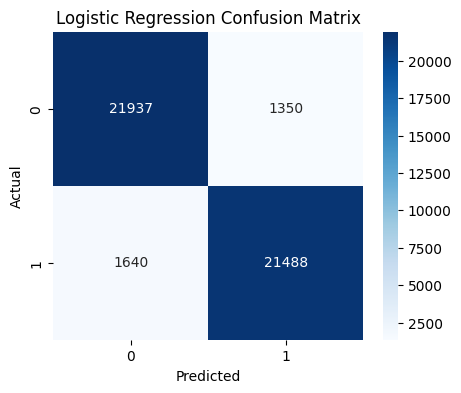

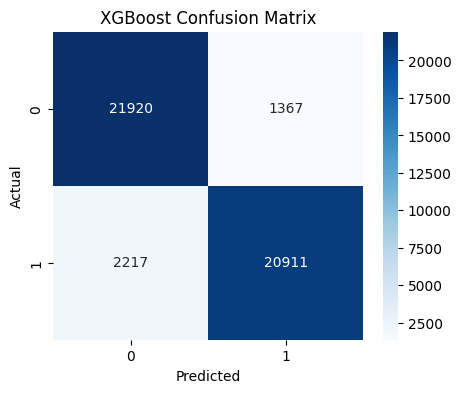

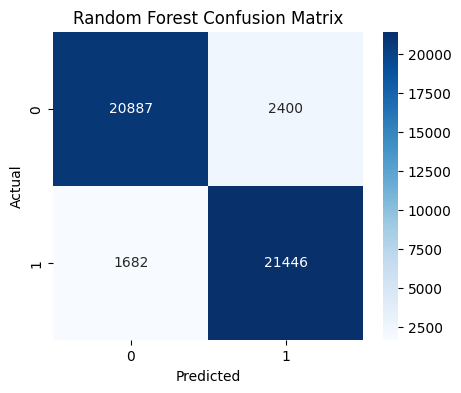

In [29]:
# Plot Confusion Matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(y_test, lr_preds, "Logistic Regression Confusion Matrix")
plot_confusion_matrix(y_test, xgb_preds, "XGBoost Confusion Matrix")
plot_confusion_matrix(y_test, rf_preds, "Random Forest Confusion Matrix")

Hyper_parameter Tunning

In [30]:
grid_LR= LogisticRegression(random_state=42)

parameters = dict()
parameters['solver'] = ['lbfgs', 'liblinear', 'newton-cholesky', 'sag','saga']
parameters['penalty'] = ['l1', 'l2', 'elasticnet',None]
parameters['max_iter'] = [100, 200, 300]

## Building Grid Search algorithm with cross-validation and acc score.

grid_search_LR = GridSearchCV(grid_LR, parameters, scoring='accuracy', cv=5, n_jobs=-1)

grid_search_LR.fit(X_train,y_train)
best_parameters_LR = grid_search_LR.best_params_
best_score_LR = grid_search_LR.best_score_
best_estimator_LR = grid_search_LR.best_estimator_
print(best_parameters_LR)
print(best_score_LR)

y_pred_LR_val = grid_search_LR.predict(X_test)
print(classification_report(y_test, y_pred_LR_val))

{'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.9336794994919927
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     23287
           1       0.94      0.93      0.94     23128

    accuracy                           0.94     46415
   macro avg       0.94      0.94      0.94     46415
weighted avg       0.94      0.94      0.94     46415



In [31]:
# pickling the model

pickle_out = open("GridSearchLR.pkl", "wb")
pickle.dump(best_estimator_LR, pickle_out)
pickle_out.close()

In [32]:
grid_XGB= XGBClassifier()
 
parameters = dict()
parameters = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6]}
 
grid_search_xgb = GridSearchCV(grid_XGB, parameters, scoring='accuracy', cv=5)
 
grid_search_xgb.fit(X_train,y_train)
best_parameters_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_
best_estimatorxgb = grid_search_xgb.best_estimator_
print(best_parameters_xgb)
print(best_score_xgb)
 
y_pred_grid_xgb = grid_search_xgb.predict(X_test)
print(classification_report(y_test, y_pred_grid_xgb))

{'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 150}
0.9219590750361559
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     23287
           1       0.94      0.90      0.92     23128

    accuracy                           0.92     46415
   macro avg       0.92      0.92      0.92     46415
weighted avg       0.92      0.92      0.92     46415



In [33]:
# pickling the model

pickle_out = open("GridSearchXGB.pkl", "wb")
pickle.dump(best_estimatorxgb, pickle_out)
pickle_out.close()

In [20]:
grid_RF= RandomForestClassifier(random_state=42)

parameters = dict()
parameters['n_estimators'] = [100, 200]
parameters['criterion'] = ['gini', 'entropy', 'log_loss']
parameters['max_depth']= [10, 20, 30]

## Building Grid Search algorithm with cross-validation and acc score.

grid_search_RF = GridSearchCV(grid_RF, parameters, scoring='accuracy', cv=5, n_jobs=-1)

grid_search_RF.fit(X_train,y_train)
best_parameters_RF = grid_search_RF.best_params_
best_score_RF = grid_search_RF.best_score_
best_estimator_RF = grid_search_RF.best_estimator_
print(best_parameters_RF)
print(best_score_RF)

y_pred_RF_val = grid_search_RF.predict(X_test)
print(classification_report(y_test, y_pred_RF_val))

{'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 200}
0.8907082366851629
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     23287
           1       0.91      0.86      0.89     23128

    accuracy                           0.89     46415
   macro avg       0.89      0.89      0.89     46415
weighted avg       0.89      0.89      0.89     46415



In [21]:
# pickling the model

pickle_out = open("GridSearchRF.pkl", "wb")
pickle.dump(best_estimator_RF, pickle_out)
pickle_out.close()